## **(SUIM DATASET TRAINING)**
# **MUGHEERA SALEEM 361466**
# **AMMAR SHAH 362244**
# **MUHAMMAD NAUMAN 364573**

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 47.0 MB/s eta 0:00:00


# **Package Imports**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2 
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
import os
import visualkeras
import sys
from PIL import Image
import time

# **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Reading File Paths**

In [ ]:
PATH = "/content/drive/MyDrive/DL Project Datasets/Segmentation Datasets/Underwater Semantic Segmentation"

train_img_names = os.listdir(os.path.join(PATH ,"train_val/images"))
print(train_img_names[0])
print(len(train_img_names))

test_img_names = os.listdir(os.path.join(PATH ,"TEST/images"))
print(test_img_names[0])
print(len(test_img_names))



f_r_1692_.jpg
1525
d_r_345_.jpg
110


# **Decoding One Training Image**

(540, 960, 3)


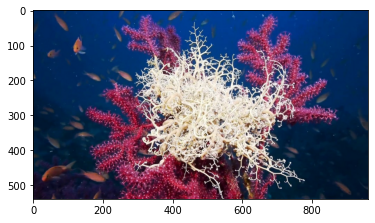

In [ ]:
image = tf.io.read_file(os.path.join(PATH,"train_val", "images",train_img_names[20]))
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.imshow(image)
print(image.shape)


# **Decoding one Test Image**

(480, 640, 3)


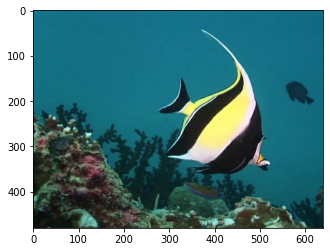

In [ ]:
image = tf.io.read_file(os.path.join(PATH,"TEST", "images",test_img_names[35]))
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.imshow(image)
print(image.shape)

# **Ordering the Train and Test Images and Masks**

In [ ]:
train_masks_names = []
test_masks_names = []

for string in train_img_names:
  string = string[:-3]+"bmp"
  #print(string)
  train_masks_names.append(string)

for string in test_img_names:
  string = string[:-3]+"bmp"
  #print(string)
  test_masks_names.append(string)

for i in range (3):
  print("Train image name:",train_img_names[i])
  print("Train mask name:",train_masks_names[i])
  print("Test image name:",test_img_names[i])
  print("Test mask name:",test_masks_names[i])

Train image name: f_r_1692_.jpg
Train mask name: f_r_1692_.bmp
Test image name: d_r_345_.jpg
Test mask name: d_r_345_.bmp
Train image name: f_r_1645_.jpg
Train mask name: f_r_1645_.bmp
Test image name: d_r_300_.jpg
Test mask name: d_r_300_.bmp
Train image name: f_r_160_.jpg
Train mask name: f_r_160_.bmp
Test image name: d_r_196_.jpg
Test mask name: d_r_196_.bmp


# **Decoding One Train Mask**

(540, 960, 1)


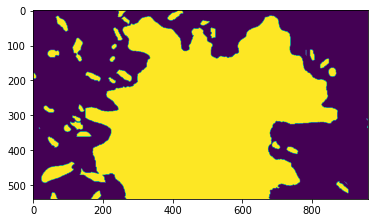

In [ ]:
mask = tf.io.read_file(os.path.join(PATH,"train_val", "masks",train_masks_names[20]))
mask = tf.image.decode_bmp(mask, channels=3)
mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

plt.imshow(tf.squeeze(mask))
print(mask.shape)

# **Decoding One Test Mask**

(480, 640, 1)


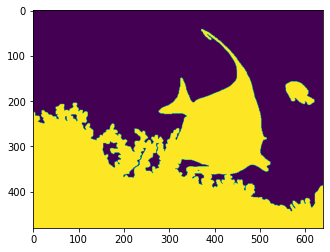

In [ ]:
mask = tf.io.read_file(os.path.join(PATH,"TEST", "masks",test_masks_names[35]))
mask = tf.image.decode_bmp(mask, channels=3)
mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

plt.imshow(tf.squeeze(mask))
print(mask.shape)

# **Creating Training Data**

In [ ]:
train_images = []
train_masks = []

for index in range(len(train_img_names)):
   image = tf.io.read_file(os.path.join(PATH,"train_val", "images",train_img_names[index]))
   image = tf.image.decode_png(image, channels=3)
   image = tf.image.convert_image_dtype(image, tf.float32)
   image = np.asarray(image)
   image = tf.image.resize(image,(256,256),method ='nearest')
   train_images.append(image)

   mask = tf.io.read_file(os.path.join(PATH,"train_val", "masks",train_masks_names[index]))
   mask = tf.image.decode_bmp(mask, channels=3)
   mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
   mask = np.asarray(mask)
   mask = tf.image.resize(mask,(256,256),method ='nearest')
   train_masks.append(mask)
   print(index)

print("Number of training images:",len(train_images))
print("Number of training masks:",len(train_masks))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# **Creating Testing Data**

In [ ]:
test_images = []
test_masks = []

for index in range(len(test_img_names)):
   image = tf.io.read_file(os.path.join(PATH,"TEST", "images",test_img_names[index]))
   image = tf.image.decode_png(image, channels=3)
   image = tf.image.convert_image_dtype(image, tf.float32)
   image = np.asarray(image)
   image = tf.image.resize(image,(256,256),method='nearest')
   test_images.append(image)

   mask = tf.io.read_file(os.path.join(PATH,"TEST", "masks",test_masks_names[index]))
   mask = tf.image.decode_bmp(mask, channels=3)
   mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
   mask = np.asarray(mask)
   mask = tf.image.resize(mask,(256,256),method='nearest')
   test_masks.append(mask)
   print(index)

print("Number of testing images:",len(test_images))
print("Number of testing masks:",len(test_masks))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
Number of testing images: 110
Number of testing masks: 110


# **Looking at some Images and Their masks**

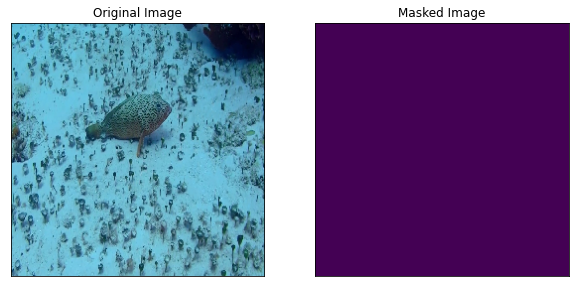

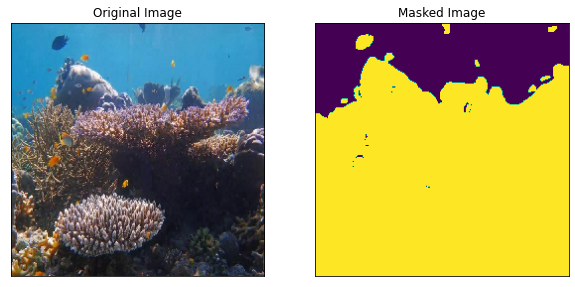

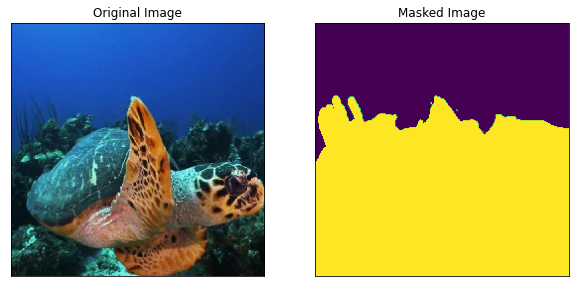

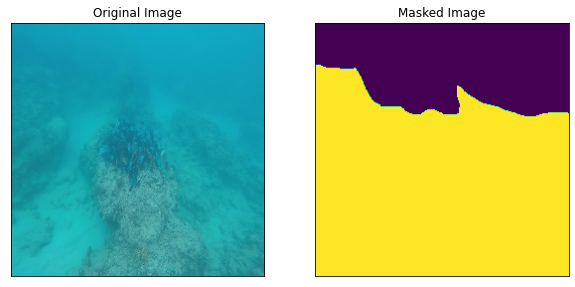

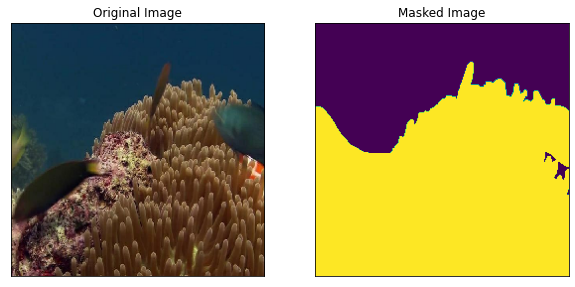

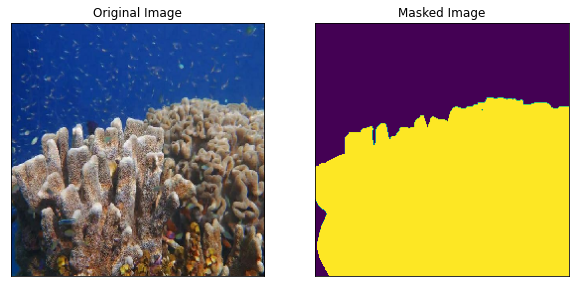

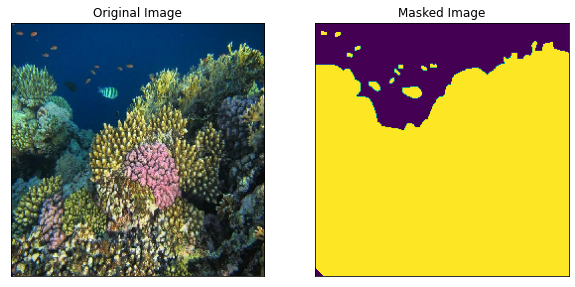

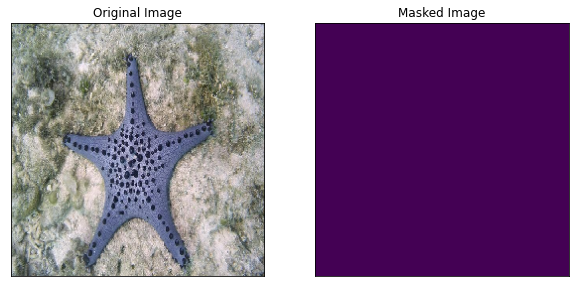

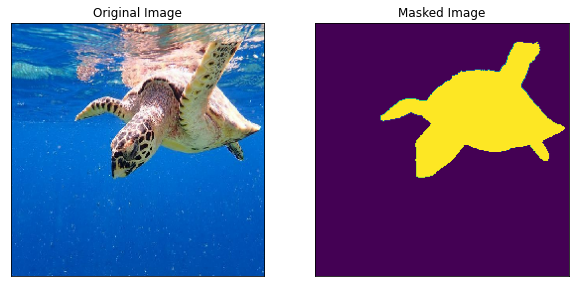

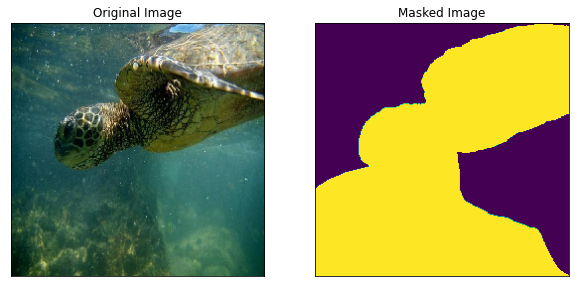

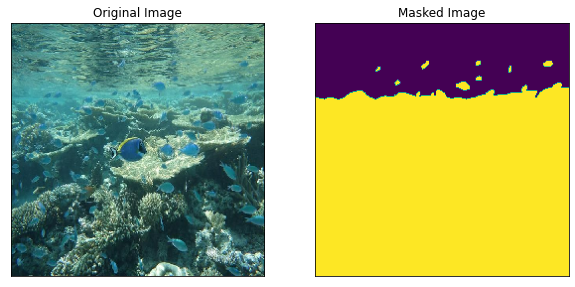

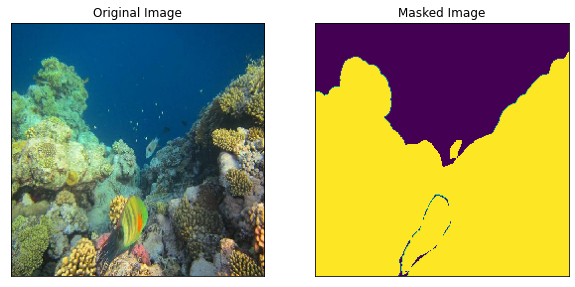

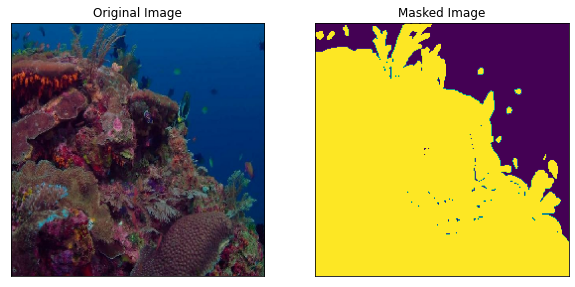

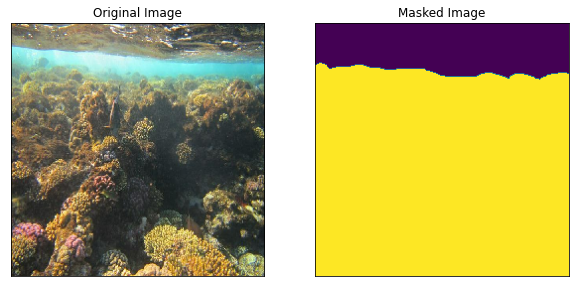

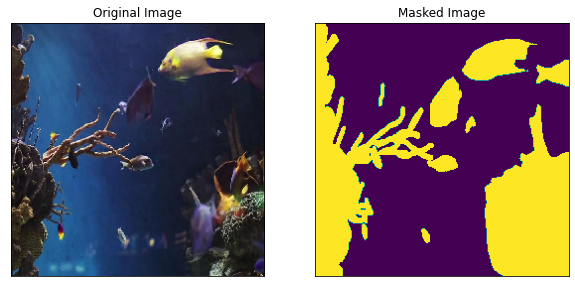

In [ ]:
N = 15

for index in range(N):
    
    image = train_images[index]
    mask = train_masks[index]

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])


    plt.subplot(1,2,2)
    plt.title("Masked Image")
    plt.imshow(tf.squeeze(mask))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# **Printing Shapes of Tensors**

In [ ]:
train_images = np.asarray(train_images)
train_masks = np.asarray(train_masks)
test_images = np.asarray(test_images)
test_masks = np.asarray(test_masks)

train_images = tf.stack(train_images,axis=0)
train_images = tf.stack(train_images,axis=0)
test_images = tf.stack(test_images,axis=0)
test_masks = tf.stack(test_masks,axis=0)

print(train_images.shape), print(train_masks.shape)
print(test_images.shape), print(test_masks.shape)

(1525, 256, 256, 3)
(1525, 256, 256, 1)
(110, 256, 256, 3)
(110, 256, 256, 1)


(None, None)

# **Finding The Number of Classes in the Masks**

In [ ]:
classes, _, _ = tf.unique_with_counts(tf.reshape(train_masks, (-1,)))
print(classes.shape)

(256,)


# **Shape Of an Input Image**

In [ ]:
print(train_images[0].shape)

(256, 256, 3)


# **Down-Sampling Conv Block**

In [ ]:
def conv_block(inputs=None, num_filters=16,kernal_size=3, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        num_filters -- Number of filters for the convolutional layers
        kernal_size -- Kernal Dimension
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv2d = tf.keras.layers.Conv2D(num_filters,(kernal_size, kernal_size),activation="relu",padding="same",kernel_initializer="he_normal")(inputs)
    
    conv2d = tf.keras.layers.Conv2D(num_filters,(kernal_size, kernal_size),activation="relu",padding="same",kernel_initializer="he_normal")(conv2d)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        dropout = tf.keras.layers.Dropout(dropout_prob)(conv2d)
    else:
        dropout = conv2d
             
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        maxpool = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(dropout)
    else:
        maxpool = dropout

    next_layer = maxpool  
    skip_connection = dropout
    
    return next_layer, skip_connection

# **Setting Input Shape for U-Net**

In [ ]:
input_shape = (128, 128, 3)
input = tf.keras.layers.Input(shape=input_shape)

# **Up-Sampling Conv Block**

In [ ]:
def upsampling_block(expansive_input, contractive_input,kernal_size=3 , num_filters=16):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        num_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    upsampled_input = tf.keras.layers.Conv2DTranspose(num_filters,(kernal_size, kernal_size),strides=2,padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tf.keras.layers.concatenate([upsampled_input, contractive_input], axis=3)
    
    conv2d = tf.keras.layers.Conv2D(num_filters,(kernal_size, kernal_size),activation="relu",padding="same",kernel_initializer="he_normal")(merge)
    
    conv2d = tf.keras.layers.Conv2D(num_filters, (kernal_size, kernal_size),activation="relu",padding="same",kernel_initializer="he_normal")(conv2d)
    
    return conv2d

# **Main Segmenter model**

In [ ]:
############# Roll ID = 361466
############# reverse & Odd = 775173

def segmenter_model(input_size=(None, None, 3), num_filters=16, num_classes=8):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        num_filters -- Number of filters for the convolutional layers
        num_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """

    inputs = tf.keras.layers.Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and num_filters
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step

    conv_block_1 = conv_block(inputs=inputs,kernal_size = 7, num_filters=num_filters * 1)
    conv_block_2 = conv_block(inputs=conv_block_1[0],kernal_size = 7, num_filters=num_filters * 2)
    conv_block_3 = conv_block(inputs=conv_block_2[0],kernal_size = 5 , num_filters=num_filters * 4)
    
    # Include a dropout of 0.3 for this layer
    conv_block_4 = conv_block(inputs=conv_block_3[0],kernal_size=1, num_filters=num_filters * 8)
    conv_block_5 = conv_block(inputs=conv_block_4[0],kernal_size=7, num_filters=num_filters * 16, dropout_prob=0.3) 
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    conv_block_6 = conv_block(inputs=conv_block_5[0],kernal_size=3, num_filters=num_filters * 32, dropout_prob=0.3, max_pooling=False)
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here, at each step, use half the number of filters of the previous block 
    # Use the conv_block_6[0] as expansive_input and conv_block_5[1] as contractive_input and num_filters * 16
    
    deconv_block_1 = upsampling_block(num_filters=num_filters * 16, expansive_input = conv_block_6[0], contractive_input = conv_block_5[1], kernal_size=3)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    deconv_block_2 = upsampling_block(num_filters=num_filters * 8, expansive_input = deconv_block_1,contractive_input = conv_block_4[1],kernal_size=7)
    deconv_block_3 = upsampling_block(num_filters=num_filters * 4, expansive_input = deconv_block_2, contractive_input = conv_block_3[1], kernal_size=1)
    deconv_block_4 = upsampling_block(num_filters=num_filters * 2, expansive_input = deconv_block_3, contractive_input = conv_block_2[1], kernal_size=5)
    deconv_block_5 = upsampling_block(num_filters=num_filters * 1, expansive_input = deconv_block_4,contractive_input = conv_block_1[1],kernal_size=7)

    conv2d = tf.keras.layers.Conv2D(filters=num_filters,kernel_size=7,activation="relu",padding="same",kernel_initializer="he_normal")(deconv_block_5)

    # Add a Conv2D layer with num_classes filter, kernel size of 1 and a 'same' padding
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same")(conv2d)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# **Instantiating the my_segmenter model**

In [ ]:
height, width, channels = train_images[0].shape

my_segmenter = segmenter_model(input_size=(height, width, channels), num_filters=32, num_classes=257) # 256 intensity values + 1 background

# **my_segmenter summary**

In [ ]:
my_segmenter.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  50208       ['conv2d[0][0]']                 
                                )                                                             

# **Compiling the model**

In [ ]:
my_segmenter.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# **my_segmenter architecture**

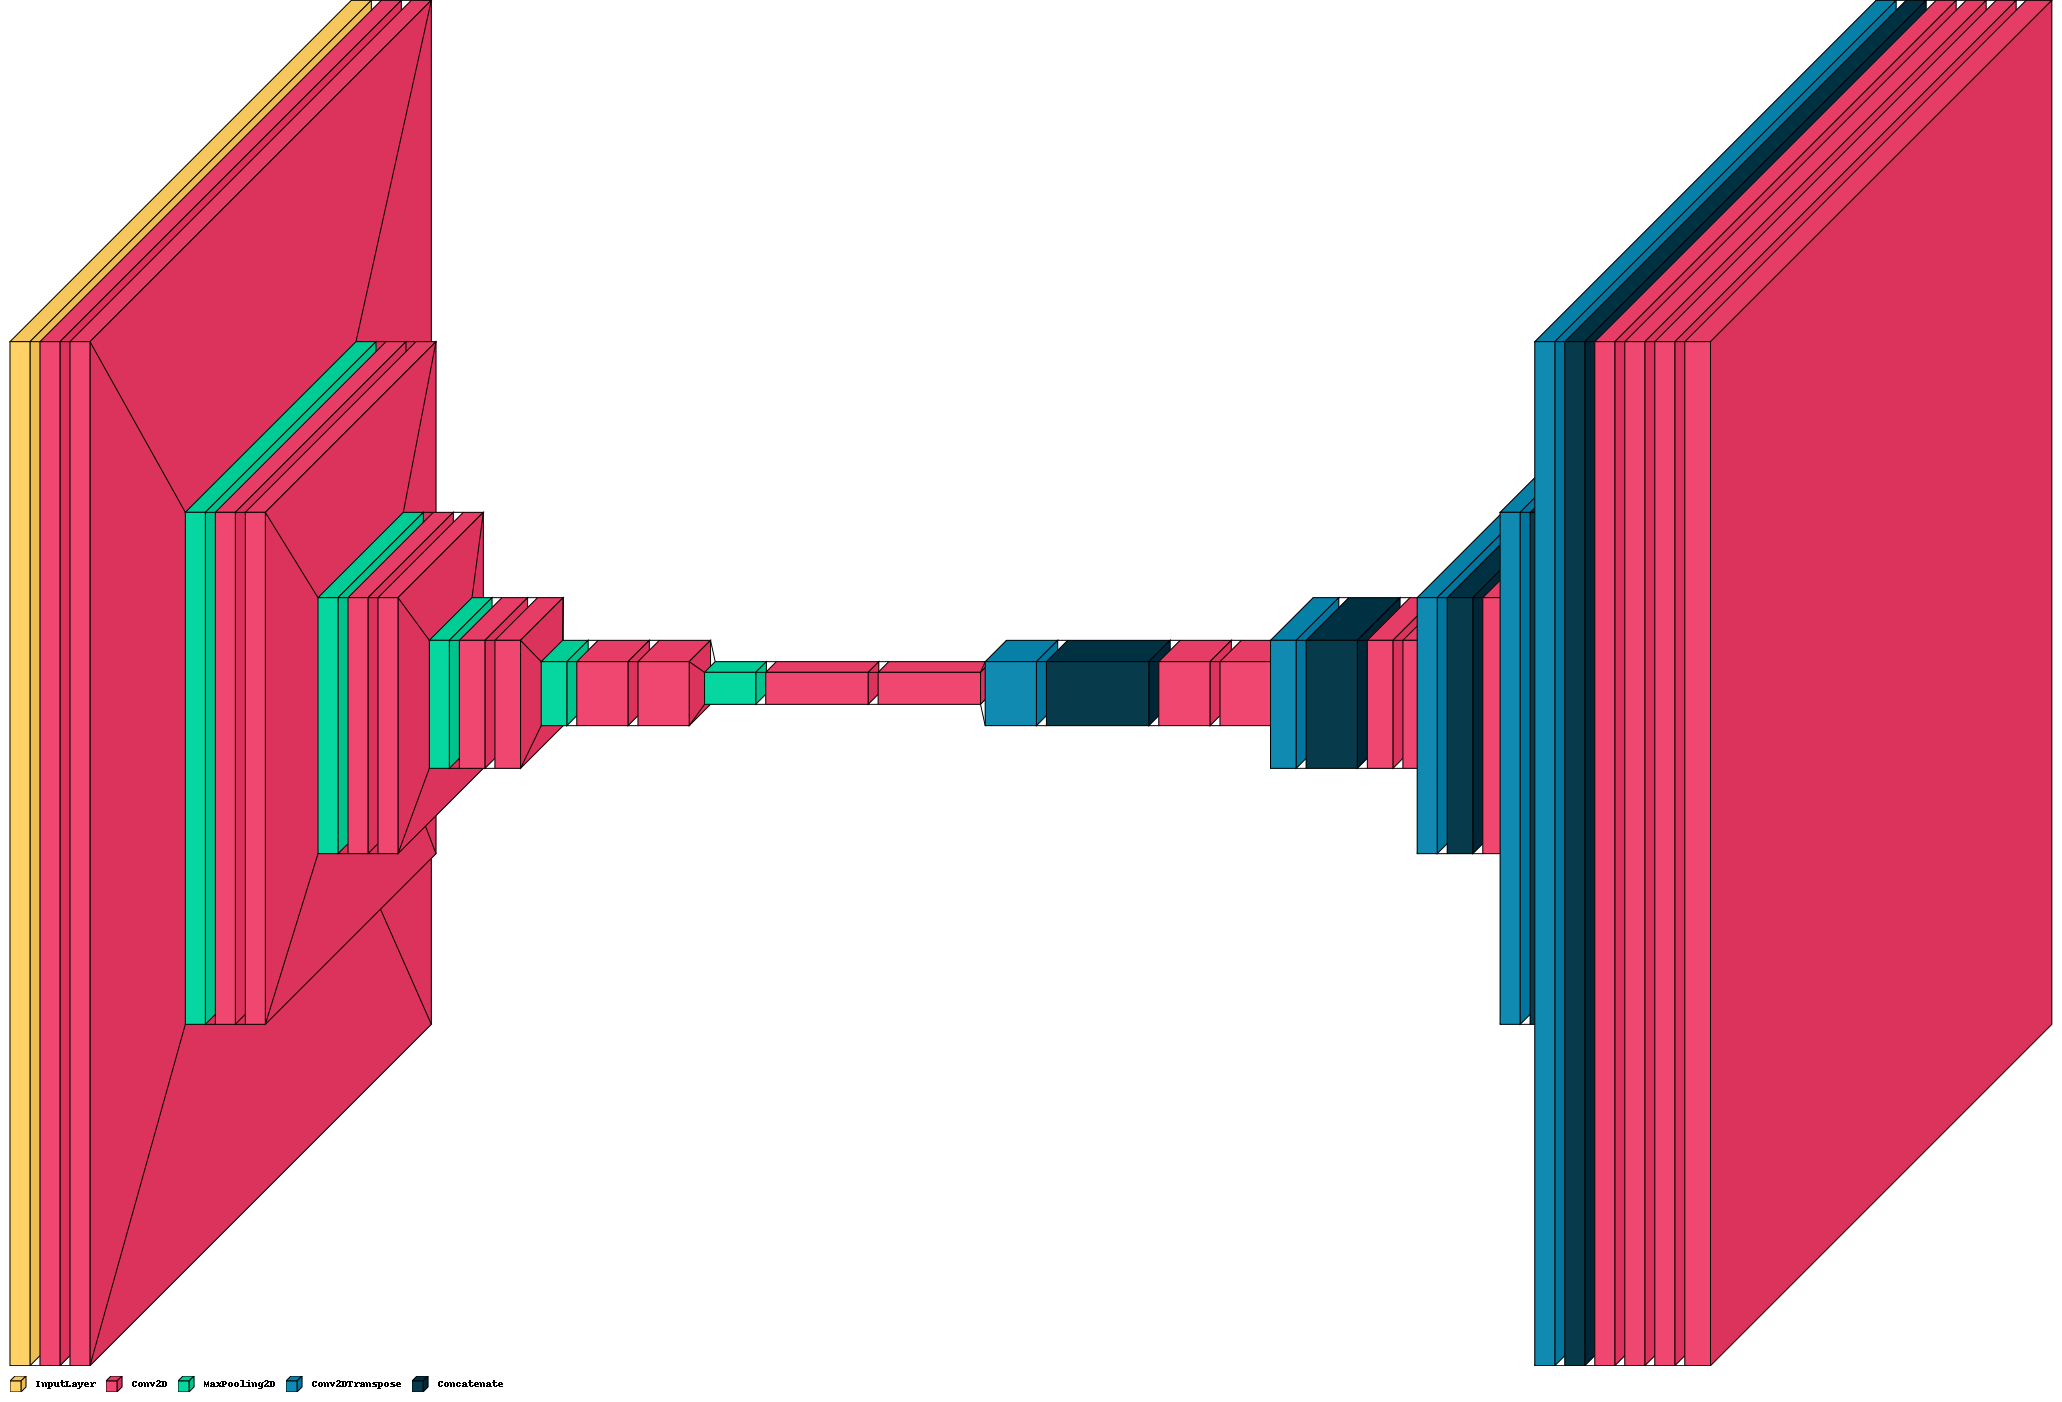

In [ ]:
from keras.layers.merging.add import Add
from keras.layers.activation.leaky_relu import LeakyReLU
from keras.layers import Dropout, BatchNormalization
visualkeras.layered_view(my_segmenter,legend=True,type_ignore=[LeakyReLU, Dropout,BatchNormalization,Add])

# **Early stopping Callback**

In [ ]:
# Callback for stopping tarining

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

# **Fitting the model**

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

start_time = time.time()

model_history = my_segmenter.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    validation_data=(test_images,test_masks),
    callbacks=[callbacks]
)
elapsed_time = time.time() - start_time
print('Time taken for training: ',elapsed_time/60,'min') 

Epoch 1/20
 6/48 [==>...........................] - ETA: 1:28 - loss: 45.2817 - accuracy: 0.3759

48/48 [==============================] - 157s 3s/step - loss: 7.3105 - accuracy: 0.4977 - val_loss: 0.6724 - val_accuracy: 0.6567
Epoch 2/20
48/48 [==============================] - 99s 2s/step - loss: 0.6780 - accuracy: 0.7196 - val_loss: 0.5147 - val_accuracy: 0.7558
Epoch 3/20
48/48 [==============================] - 100s 2s/step - loss: 0.5026 - accuracy: 0.7951 - val_loss: 0.4561 - val_accuracy: 0.7752
Epoch 4/20
48/48 [==============================] - 100s 2s/step - loss: 0.4951 - accuracy: 0.8035 - val_loss: 0.4398 - val_accuracy: 0.8119
Epoch 5/20
48/48 [==============================] - 99s 2s/step - loss: 0.6643 - accuracy: 0.7553 - val_loss: 0.4855 - val_accuracy: 0.7592
Epoch 6/20
48/48 [==============================] - 99s 2s/step - loss: 0.5208 - accuracy: 0.7684 - val_loss: 0.4642 - val_accuracy: 0.7607
Epoch 7/20
48/48 [==============================] - 100s 2s/step - loss: 0.5025 - accuracy: 0.7755 - val_loss: 0.4627 - val_accuracy: 0.7679
Epoch 8/20
48/48 [=========

# **Plotting helper function**

In [ ]:
# plt.plot(model_history.history["accuracy"])

def summarize_diagnostics(history):
	# plot loss
	plt.subplot(121)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(122)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	#plt.close()

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

start_time = time.time()

model_history = my_segmenter.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    validation_data=(test_images,test_masks),
    callbacks=[callbacks]
)
elapsed_time = time.time() - start_time
print('Time taken for training: ',36.06 +elapsed_time/60,'min') 

Epoch 1/20
 6/48 [==>...........................] - ETA: 1:26 - loss: 0.2745 - accuracy: 0.8973

48/48 [==============================] - 100s 2s/step - loss: 0.2979 - accuracy: 0.8953 - val_loss: 0.2614 - val_accuracy: 0.9003
Epoch 2/20
48/48 [==============================] - 100s 2s/step - loss: 0.3096 - accuracy: 0.8902 - val_loss: 0.2393 - val_accuracy: 0.9057
Epoch 3/20
48/48 [==============================] - 100s 2s/step - loss: 0.2867 - accuracy: 0.8990 - val_loss: 0.2317 - val_accuracy: 0.9097
Epoch 4/20
48/48 [==============================] - 100s 2s/step - loss: 0.3004 - accuracy: 0.8966 - val_loss: 0.2465 - val_accuracy: 0.9043
Epoch 5/20
48/48 [==============================] - 100s 2s/step - loss: 0.3225 - accuracy: 0.8850 - val_loss: 0.2356 - val_accuracy: 0.9093
Epoch 6/20
48/48 [==============================] - 100s 2s/step - loss: 0.2933 - accuracy: 0.8993 - val_loss: 0.2396 - val_accuracy: 0.9048
Epoch 7/20
48/48 [==============================] - 100s 2s/step - loss: 0.2936 - accuracy: 0.8996 - val_loss: 0.2392 - val_accuracy: 0.9115
Epoch 8/20
48/48 [======

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20

start_time = time.time()

model_history = my_segmenter.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    validation_data=(test_images,test_masks),
    callbacks=[callbacks]
)
elapsed_time = time.time() - start_time
print('Time taken for training: ',69.28 +elapsed_time/60,'min') 

Epoch 1/20
 6/48 [==>...........................] - ETA: 1:24 - loss: 0.2248 - accuracy: 0.9240

48/48 [==============================] - 100s 2s/step - loss: 0.2378 - accuracy: 0.9206 - val_loss: 0.2414 - val_accuracy: 0.9146
Epoch 2/20
48/48 [==============================] - 100s 2s/step - loss: 0.2430 - accuracy: 0.9177 - val_loss: 0.2140 - val_accuracy: 0.9283
Epoch 3/20
48/48 [==============================] - 100s 2s/step - loss: 0.2441 - accuracy: 0.9191 - val_loss: 0.2081 - val_accuracy: 0.9231
Epoch 4/20
48/48 [==============================] - 100s 2s/step - loss: 0.2404 - accuracy: 0.9201 - val_loss: 0.2793 - val_accuracy: 0.8858
Epoch 5/20
48/48 [==============================] - 100s 2s/step - loss: 0.2316 - accuracy: 0.9237 - val_loss: 0.2092 - val_accuracy: 0.9212
Epoch 6/20
48/48 [==============================] - 100s 2s/step - loss: 0.2262 - accuracy: 0.9244 - val_loss: 0.1974 - val_accuracy: 0.9263
Epoch 7/20
48/48 [==============================] - 100s 2s/step - loss: 0.2264 - accuracy: 0.9251 - val_loss: 0.1965 - val_accuracy: 0.9284
Epoch 8/20
48/48 [======

# **Evaluating the model on test images**

> 88.795
> 0.286


['loss', 'accuracy']

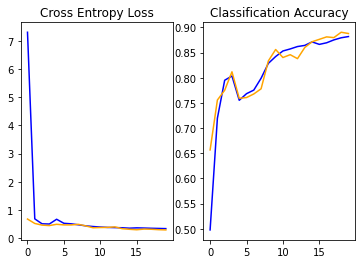

In [ ]:
loss, acc = my_segmenter.evaluate(test_images,test_masks, verbose=0)
print('> %.3f' % (acc * 100.0))
print('> %.3f' %loss)
# learning curves
summarize_diagnostics(model_history)
my_segmenter.metrics_names

# **Displaying results functions**

In [ ]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
   
    plt.show()

# **Mask creating helper function**

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# **Displaying results**

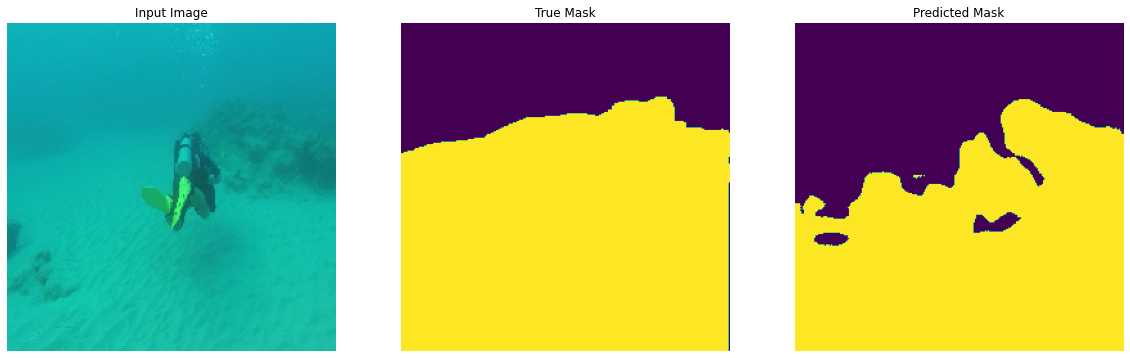

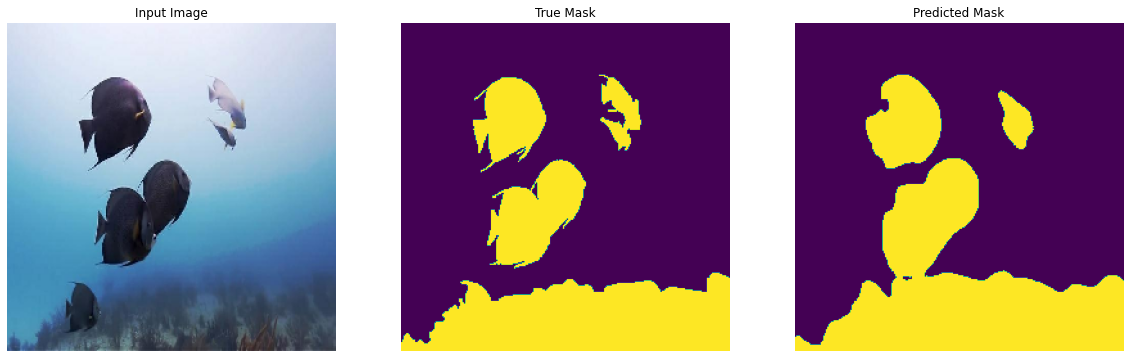

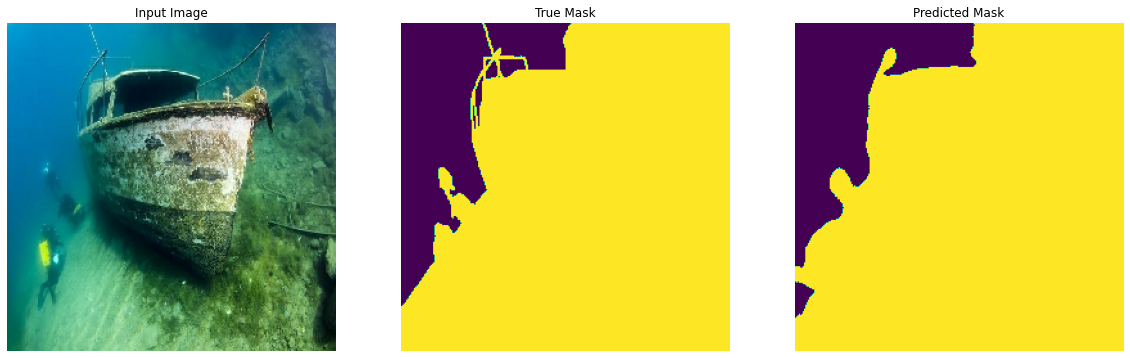

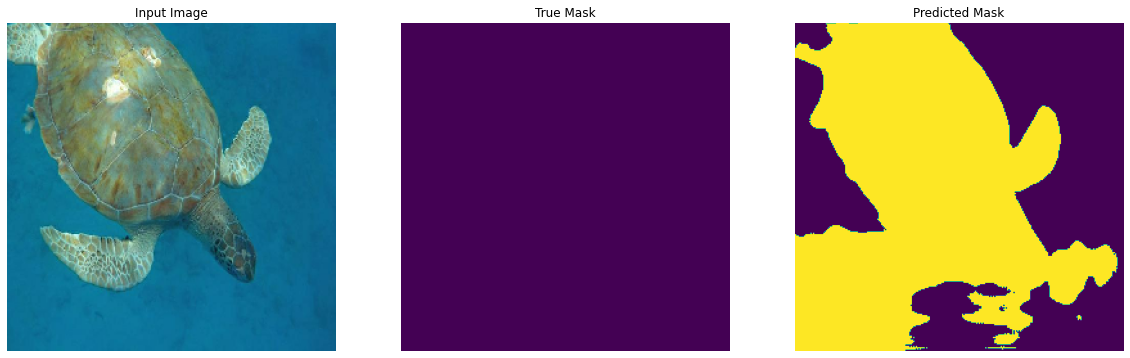

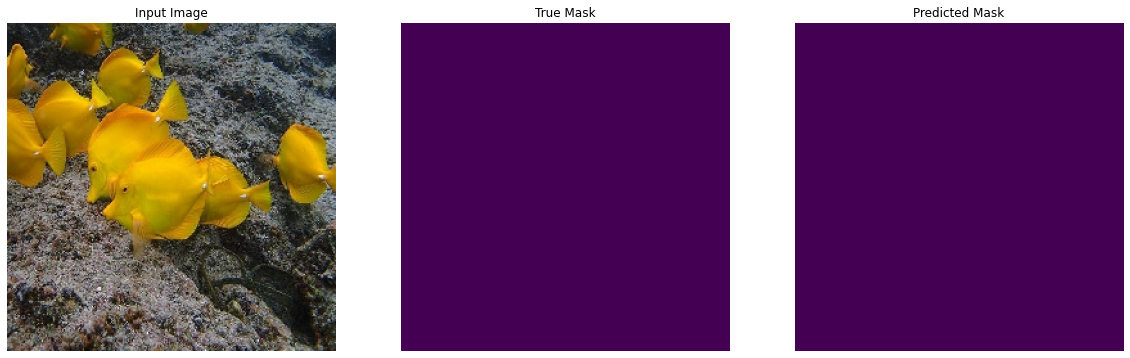

In [ ]:
for i in range(76,81):
    index = np.random.randint(test_images.shape[0])

    input_image = test_images[index]
    true_mask = test_masks[index]
    
    pred_mask = my_segmenter(tf.expand_dims(input_image, axis=0))
    pred_mask = create_mask(pred_mask)

    display([input_image, true_mask, pred_mask])

# **Saving model in g-drive**

In [ ]:
my_segmenter.save('/content/drive/MyDrive/DL Trained Models/SUIM_2_model')

In [ ]:
# !mkdir -p saved_model
# my_segmenter.save('saved_model/SUIM_2_model')

In [ ]:
# !zip -r /content/SUIM_2_model.zip /content/saved_model/SUIM_2_model

# **Loading model and printing summary**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/DL Trained Models/SUIM_2_model')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  50208       ['conv2d[0][0]']                 
                                )                                                             